In [1]:
import time
import numpy as np
import pymc3 as pm
import pandas as pd
from tqdm import tqdm
import os

from numba import jit

import arviz as az
import matplotlib.pyplot as plt

import theano
import theano.tensor as t
from scipy.integrate import solve_ivp

THEANO_FLAGS = 'optimizer=None', 'exception_verbosity=high'
SEED = 1234

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Leitura e tratamento dos arquivos csv gerados

dfB2 = pd.read_csv(r"C:\Users\thais\Downloads\dados_capturados_mistura6\mix1-1_4000novo.csv", sep=';', header=None)
dfB2.columns = ['hours', 'cell_index']
dfB2 = dfB2.replace({',':'.'}, regex=True)
dfB2 = dfB2.astype(float)
#dfS2.info()

In [3]:
#obter somente menores do que 97 horas

dfb2 = dfB2[dfB2['hours'] < 97]
print(len(dfb2))

87


In [4]:
xdados2 = np.array(dfb2['hours'].values)
ydados2 = np.array(dfb2['cell_index'].values)

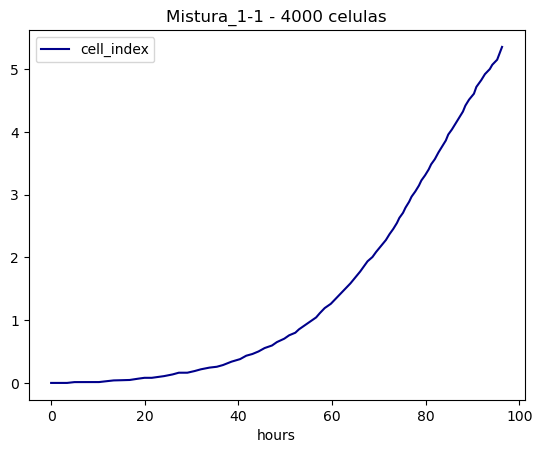

In [5]:
dfb2.plot(x='hours', y='cell_index', c='DarkBlue', title='Mistura_1-1 - 4000 celulas')
plt.show()

In [6]:
# Modelo
def model01(t, X, tauc, taustar, s0, r0):
    S,R = X
    taus = 13.4731
    taur = 15.0754
    K = 8.2538
    
    dSdt = S/taus * (1 - (R + S)/K) - (S * R)/tauc + R/taustar
    dRdt = R/taur * (1 - (R + S)/K) + (S * R)/tauc - R/taustar
    
    return dSdt, dRdt

In [7]:
@theano.compile.ops.as_op(itypes=[t.dvector, t.dscalar, t.dscalar, t.dscalar, t.dscalar], otypes=[t.dvector])
def wrapper1(time_exp2, tauc, taustar, s0, r0):
    t_span2 = (0.00, time_exp2.max())

    y02 = np.array([s0,r0])    
    y_model2 =  solve_ivp(
        fun = lambda t, y: model01(t, y, tauc=tauc, taustar=taustar, s0=s0, r0=r0),
        t_span=t_span2,
        y0=y02,
        t_eval=time_exp2,
        rtol=1e-5,
        atol=1e-7,
        method='RK45'    
    )

    simulated_time2 = y_model2.t
    simulated_ode_solution2 = y_model2.y
    S2,R2 = simulated_ode_solution2
    sum_vec = sum([S2,R2])
    
    return sum_vec

In [8]:
print('\n*** Performing Bayesian Calibration ***')
print('-- Running Monte Carlo Simulations')

y_conc = ydados2 
observations = y_conc #ydados2
draws = 5000
start_time = time.time()

with pm.Model() as model_smc:

#Priors
    
    tauc = pm.Uniform('tauc', lower=1.0, upper=4.5)
    taustar = pm.Uniform('taustar', lower=5.0, upper=15.0)
    s0 = pm.Uniform('s0', lower=0.001, upper=1.0)
    r0 = pm.Uniform('r0', lower=0.001, upper=1.0)

    #simulando para 1-1
    fitting_model = pm.Deterministic(
        'model01',
        wrapper1(
            theano.shared(xdados2),
            tauc,
            taustar,
            s0,
            r0
        )
    )

    likelihood_model = pm.Normal('likelihood_model', mu=fitting_model, sigma=0.001, observed=observations)
    trace_calibration1 = pm.sample_smc(draws, chains=1, parallel=False, cores=1, random_seed = SEED)

duration = time.time() - start_time
print(f'-- Monte Carlo simulations done in {duration / 60:.3f} minutes.')


*** Performing Bayesian Calibration ***
-- Running Monte Carlo Simulations


Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.000
Stage:   5 Beta: 0.000
Stage:   6 Beta: 0.000
Stage:   7 Beta: 0.000
Stage:   8 Beta: 0.000
Stage:   9 Beta: 0.000
Stage:  10 Beta: 0.000
Stage:  11 Beta: 0.000
Stage:  12 Beta: 0.000
Stage:  13 Beta: 0.000
Stage:  14 Beta: 0.000
Stage:  15 Beta: 0.000
Stage:  16 Beta: 0.000
Stage:  17 Beta: 0.000
Stage:  18 Beta: 0.000
Stage:  19 Beta: 0.000
Stage:  20 Beta: 0.000
Stage:  21 Beta: 0.000
Stage:  22 Beta: 0.000
Stage:  23 Beta: 0.000
Stage:  24 Beta: 0.000
Stage:  25 Beta: 0.000
Stage:  26 Beta: 0.000
Stage:  27 Beta: 0.000
Stage:  28 Beta: 0.000
Stage:  29 Beta: 0.000
Stage:  30 Beta: 0.000
Stage:  31 Beta: 0.000
Stage:  32 Beta: 0.000
Stage:  33 Beta: 0.000
Stage:  34 Beta: 0.000
Stage:  35 Beta: 0.000
Stage:  36 Beta: 0.000
Stage:  37 Beta: 0.000
Stage:  38 Beta: 0.000
Stage:  39 Beta: 0.000
Stage:  40 Beta: 0.000
Sta

Stage: 354 Beta: 0.016
Stage: 355 Beta: 0.016
Stage: 356 Beta: 0.017
Stage: 357 Beta: 0.018
Stage: 358 Beta: 0.019
Stage: 359 Beta: 0.019
Stage: 360 Beta: 0.020
Stage: 361 Beta: 0.022
Stage: 362 Beta: 0.023
Stage: 363 Beta: 0.025
Stage: 364 Beta: 0.026
Stage: 365 Beta: 0.029
Stage: 366 Beta: 0.031
Stage: 367 Beta: 0.034
Stage: 368 Beta: 0.038
Stage: 369 Beta: 0.042
Stage: 370 Beta: 0.047
Stage: 371 Beta: 0.052
Stage: 372 Beta: 0.059
Stage: 373 Beta: 0.065
Stage: 374 Beta: 0.071
Stage: 375 Beta: 0.075
Stage: 376 Beta: 0.077
Stage: 377 Beta: 0.079
Stage: 378 Beta: 0.081
Stage: 379 Beta: 0.083
Stage: 380 Beta: 0.085
Stage: 381 Beta: 0.087
Stage: 382 Beta: 0.090
Stage: 383 Beta: 0.094
Stage: 384 Beta: 0.097
Stage: 385 Beta: 0.102
Stage: 386 Beta: 0.108
Stage: 387 Beta: 0.114
Stage: 388 Beta: 0.121
Stage: 389 Beta: 0.129
Stage: 390 Beta: 0.138
Stage: 391 Beta: 0.147
Stage: 392 Beta: 0.156
Stage: 393 Beta: 0.166
Stage: 394 Beta: 0.176
Stage: 395 Beta: 0.186
Stage: 396 Beta: 0.196
Stage: 397 

-- Monte Carlo simulations done in 1123.282 minutes.


Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable DF
Could not locate executable efl


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


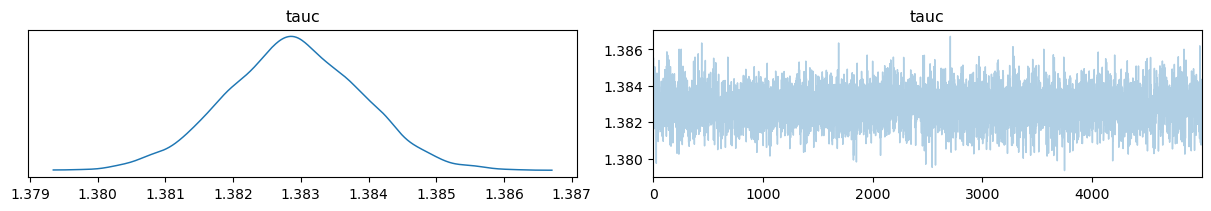

C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


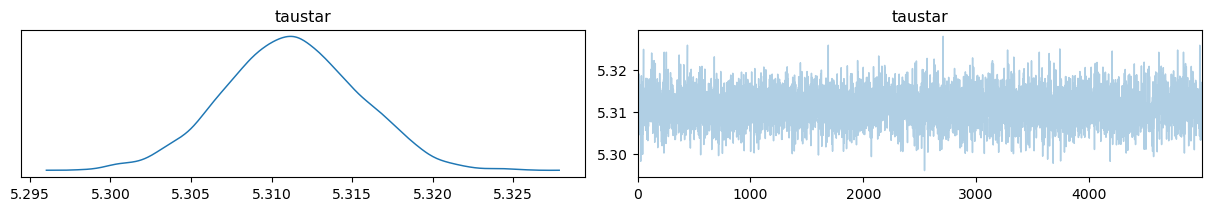

C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


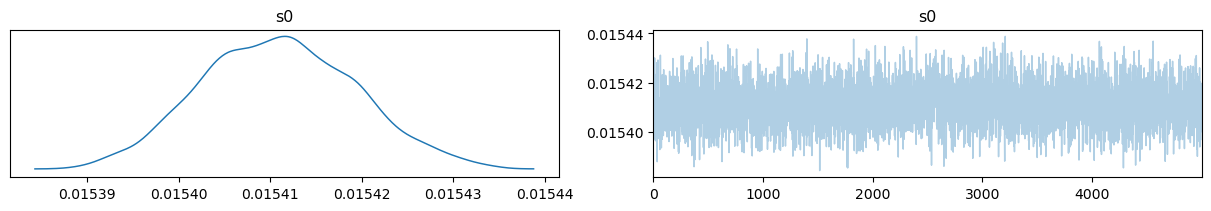

C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


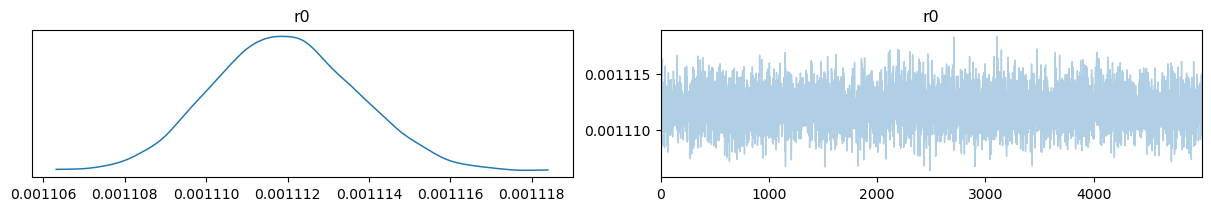

In [9]:
#Plot de cada cadeia

az.plot_trace(trace_calibration1, var_names=('tauc'))
plt.savefig('cadeia-tau_c4000-M3_1-1.png')
plt.show()

az.plot_trace(trace_calibration1, var_names=('taustar'))
plt.savefig('cadeia-tau_star4000-M3_1-1.png')
plt.show()

az.plot_trace(trace_calibration1, var_names=('s0'))
plt.savefig('cadeia-s0-4000-M3_1-1.png')
plt.show()

az.plot_trace(trace_calibration1, var_names=('r0'))
plt.savefig('cadeia-r0-4000-M3_1-1.png')
plt.show()

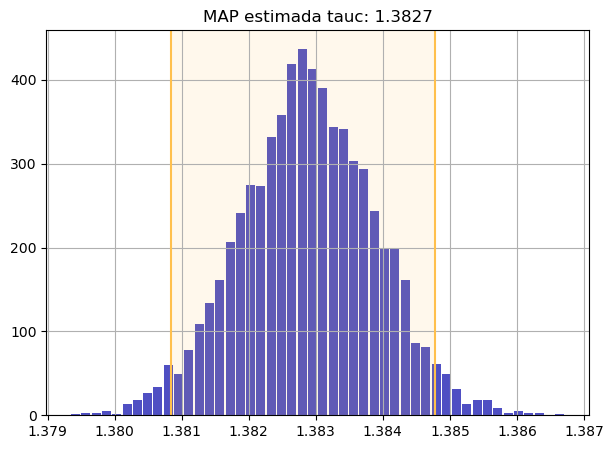

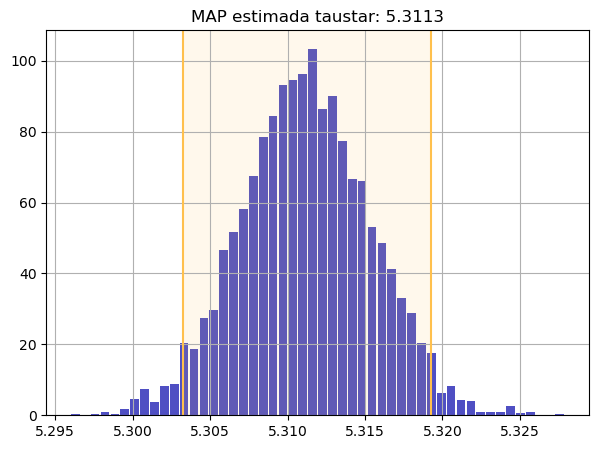

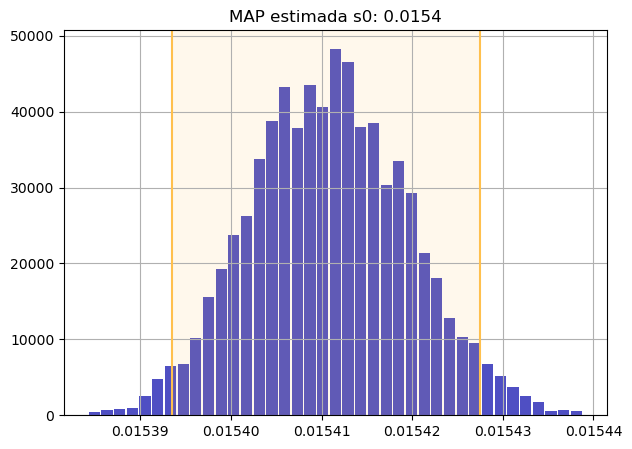

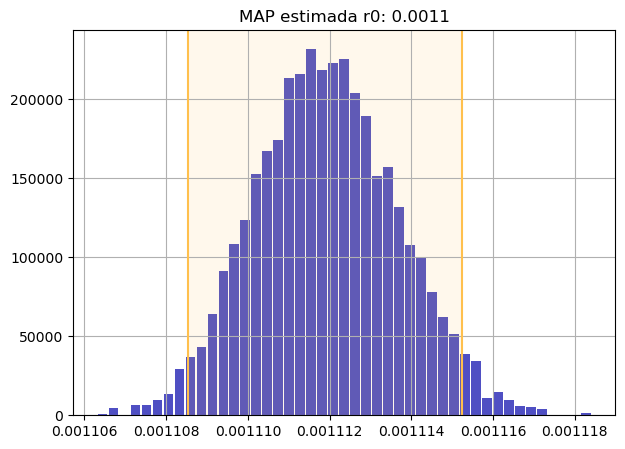

In [16]:
import arviz

fig, ax = plt.subplots(figsize = (7, 5))
#fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)


n, bins, patches = plt.hist(x=trace_calibration1['tauc'], bins='auto', density = True, color='#0504aa', alpha=0.7, rwidth=0.88, label = 'Posterior')

cred_interv = arviz.hdi(trace_calibration1['tauc'], hdi_prob = 0.95)
plt.axvline(x=cred_interv[0], color = '#ffc04d')
plt.axvline(x=cred_interv[1], color = '#ffc04d')
plt.axvspan(cred_interv[0], cred_interv[1], facecolor='#ffc04d', alpha=0.1, label = 'Cred. Interv.')
    
plt.title('MAP estimada tauc: {0:.4f}'.format(bins[np.argmax(n)]) )
plt.grid()
plt.savefig('MAP_tauc_temporarias-4000_M3_1-1.png')
plt.show()


fig, ax = plt.subplots(figsize = (7, 5))

n, bins, patches = plt.hist(x=trace_calibration1['taustar'], bins='auto', density = True, color='#0504aa', alpha=0.7, rwidth=0.88, label = 'Posterior')

cred_interv = arviz.hdi(trace_calibration1['taustar'], hdi_prob = 0.95)
plt.axvline(x=cred_interv[0], color = '#ffc04d')
plt.axvline(x=cred_interv[1], color = '#ffc04d')
plt.axvspan(cred_interv[0], cred_interv[1], facecolor='#ffc04d', alpha=0.1, label = 'Cred. Interv.')
    
plt.title('MAP estimada taustar: {0:.4f}'.format(bins[np.argmax(n)]))
plt.grid()
plt.savefig('MAP_taustar_temporarias-4000-M3_1-1.png')
plt.show()


fig, ax = plt.subplots(figsize = (7, 5))

n, bins, patches = plt.hist(x=trace_calibration1['s0'], bins='auto', density = True, color='#0504aa', alpha=0.7, rwidth=0.88, label = 'Posterior')

cred_interv = arviz.hdi(trace_calibration1['s0'], hdi_prob = 0.95)
plt.axvline(x=cred_interv[0], color = '#ffc04d')
plt.axvline(x=cred_interv[1], color = '#ffc04d')
plt.axvspan(cred_interv[0], cred_interv[1], facecolor='#ffc04d', alpha=0.1, label = 'Cred. Interv.')
    
plt.title('MAP estimada s0: {0:.4f}'.format(bins[np.argmax(n)]))
plt.grid()
plt.savefig('MAP_s0-4000_M3_1-1.png')
plt.show()


fig, ax = plt.subplots(figsize = (7, 5))

n, bins, patches = plt.hist(x=trace_calibration1['r0'], bins='auto', density = True, color='#0504aa', alpha=0.7, rwidth=0.88, label = 'Posterior')

cred_interv = arviz.hdi(trace_calibration1['r0'], hdi_prob = 0.95)
plt.axvline(x=cred_interv[0], color = '#ffc04d')
plt.axvline(x=cred_interv[1], color = '#ffc04d')
plt.axvspan(cred_interv[0], cred_interv[1], facecolor='#ffc04d', alpha=0.1, label = 'Cred. Interv.')
    
plt.title('MAP estimada r0: {0:.4f}'.format(bins[np.argmax(n)]))
plt.grid()
plt.savefig('MAP_r0-4000_M3_1-1.png')
plt.show()

In [11]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration1["model01"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration1["model01"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration1["model01"], 50, axis=0)

In [12]:
y_min[0:87]

print(len(y_min[0:87]))

minimo = np.reshape(y_min[0:87], (87,))

print(len(minimo))

y_max[0:87]

print(len(y_max[0:87]))

maximo = np.reshape(y_max[0:87], (87,))

print(len(maximo))

y_fit[0:87]

print(len(y_fit[0:87]))

fit = np.reshape(y_fit[0:87], (87,))

print(len(fit))

87
87
87
87
87
87


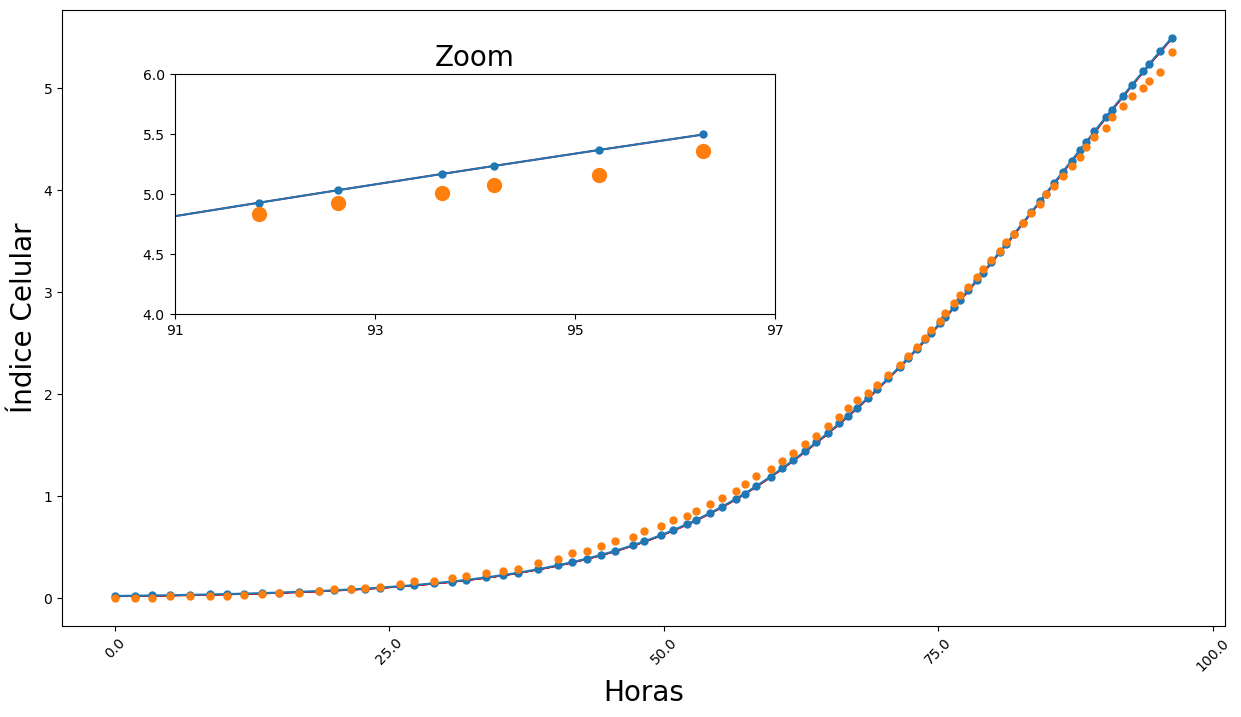

In [14]:
plt.figure(figsize=(15, 8))

# criação do primeiro conjunto de eixos
ax1 = plt.axes() 
ax1.plot(
    xdados2,
    fit,
    label="Simulação",
    marker=".",
    linestyle="-",
    markersize=10,
)
ax1.fill_between(xdados2, minimo, maximo, color="r", alpha=1.0)
ax1.plot(
    xdados2, ydados2, label="Dados células temporárias (2)", marker="o", linestyle="", markersize=5
)
#plt.grid()
t = np.linspace(0, 100, 5)
#ax1.legend(shadow=True)
ax1.set_xticks(t)
ax1.set_xticklabels(t, rotation=45)
ax1.set_xlabel('Horas', fontsize=20)
ax1.set_ylabel('Índice Celular', fontsize=20)

#plt.legend(loc="lower right")

# criação do segundo conjunto de eixos
ax2 = plt.axes([0.2, 0.5, 0.4, 0.3])
ax2.plot(xdados2, fit, marker=".", linestyle="-", markersize=10)
ax2.fill_between(xdados2, minimo, maximo, color="r", alpha=1.0)
ax2.plot(xdados2, ydados2,  marker="o", linestyle="", markersize=10)
ax2.set_xlim(91.0, 97.0)
ax2.set_ylim(4.0, 6.0)
ax2.set_xticks([91.0, 93.0, 95.0, 97.0])
ax2.set_yticks([4.0, 4.5, 5.0, 5.5, 6.0])
#ax2.set_xlabel('Horas', fontsize=15)
#ax2.set_ylabel('Índice Celular', fontsize=15)
ax2.set_title('Zoom', fontsize=20)

plt.savefig('matplotlib_mistura_M3_1-1.png')

plt.show()

In [15]:
#Critério BIC

soma_logis = sum((fit - ydados2)**2.0)

def bic(sum_qd, qt_params, vec_size):
    
    return (vec_size * np.log(sum_qd / vec_size) + qt_params * np.log(vec_size))

bic_result = bic(soma_logis,4,87)

print(bic_result)

-456.90089954702205
